# Time Integration of Ordinary Differential Equations Using DifferentialEquation.jl

In this notebook we perform time-integration of various of (systems of) ordinary differential equations. 

In [1]:
using LinearAlgebra
using DifferentialEquations
#using ModelingToolkit
using Plots 

Documentation of `DifferentialEquations.jl`

<ul>
<li> <a href="https://docs.sciml.ai/DiffEqDocs/stable/tutorials/ode_example/"> Examples </a>   
<li> <a href="https://diffeq.sciml.ai/stable/"> Documentation of DifferentialEquations.jl on Github </a>  
<li> <a href="https://diffeq.sciml.ai/dev/features/performance_overloads/#Function-Type-Definitions"> Specifying Jacobian types using DifferentialEquations.jl </a>   
</ul>   
Documentation of ModelingToolkit.jl (for ODE with parameters)
<ul>
<li> <a href="https://mtk.sciml.ai/stable/"> Documentation of ModelingToolkit.jl on Github </a>    
</ul> 
Documentation of DiffEqOperators.jl (for finite difference discretization of PDEs)
<ul>
<li> <a href="https://github.com/SciML/DiffEqOperators.jl"> Documentation of DiffEqOperators.jl on Github (soon to be deprecated) </a>    
</ul> 
Documentation of ParallelStencil.jl (for finite difference discretization of PDEs)
<ul>
<li> <a href="https://github.com/omlins/ParallelStencil.jl"> Documentation of ParallelStencil.jl on Github </a>   </ul>
Documentation of Gridap.jl (for finite element discretization of PDEs)
<ul>
<li> <a href="https://github.com/gridap/Gridap.jl"> Documentation of Gridap.jl on Github </a>   
</ul>
Documentation of Catalist.jl (for chemical reaction mechanisms)
<ul>
<li> <a href="https://catalyst.sciml.ai/stable/"> Documentation of Catalist.jl</a>    
</ul> 
Documentation of ReactionMechanismSimulator.jl (again for chemical reaction mechanisms)
<ul>
<li> <a href="https://docs.sciml.ai/ReactionMechanismSimulator/stable/"> Documentation of ReactionMechanismSimulator.jl</a>    
</ul>
Documentation on GRI-30 mechanism (as example of a chemical reaction mechanism)
<ul>
<li> <a href="https://cantera.org/tutorials/python-tutorial.html"> GRI30.xml </a>  
<li> <a href="https://discourse.julialang.org/t/calling-chemical-kinetics-solvers-like-chemkin-or-cantera-from-julia/50568/2"> Reading mechanism into Julia</a> (using Python interface to Cantera) 
</ul>

## Part 1/: Single ODE Example: Linear Right-Hand Side Function 

This example was taken from https://docs.sciml.ai/DiffEqDocs/stable/tutorials/ode_example/#Example-1-:-Solving-Scalar-Equations For this example, a reference solution can be constructed using seperation of variables (or using sympy, or wolframalpha). We also plot the time-step evoution.

In this example we solve
$$
\frac{du}{dt} = f(u,p,t)
$$

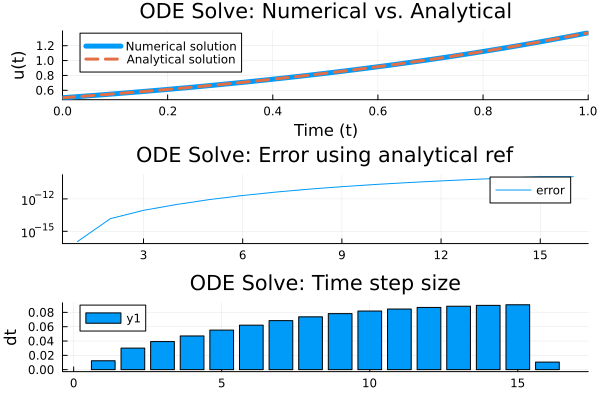

In [4]:
# problem set-up: set driving function 
f(u,p,t) = 1.01*u
# problem set-up: set initial guess 
u0=1/2
# problem set-up: set the time span 
tspan = (0.0,1.0)
# set ODE function (not strictly necessary at this stage)
ff = ODEFunction(f)
# problem set-up: define the ODE problem 
prob = ODEProblem(ff,u0,tspan)

# perform time integration 
sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8)

#sol = solve(prob,Tsit5())

# compute the time step 
dt = collect(sol.t[i+1]-sol.t[i] for i in 1:length(sol.t)-1) # same as a list comprehension

sampled = collect(0.5*exp(1.01t) for t in sol.t) # analytical solution

merror = abs.(sol.u - sampled)

# plot numerical and analytical solution 
p1=plot(sol,linewidth=5,title="ODE Solve: Numerical vs. Analytical",
     xaxis="Time (t)",yaxis="u(t)",label="Numerical solution") # legend=false

p1=plot!(sol.t, t->0.5*exp(1.01t),lw=3,ls=:dash,label="Analytical solution");

p2=plot(merror[2:end], yaxis=:log, label="error", title="ODE Solve: Error using analytical ref");

p3=bar(dt,yaxis="dt", title="ODE Solve: Time step size"); 

plot(p1,p2,p3,layout=(3,1))

In [7]:
display(prob);

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 1.0)
u0: 0.5

## Part 2/: Single ODE Example: Non-Linear Right-Hand Side

In this example, the analytical reference solution can still be found using seperation of variables (or using sympy or wolframpalpha). 

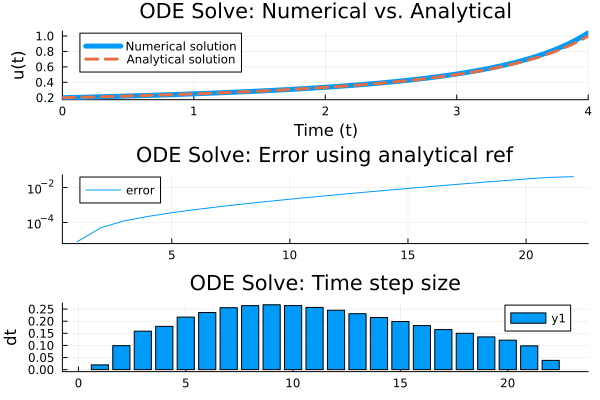

In [4]:
# problem set-up: set driving function 
f(u,p,t) = 1.01*u*u
# problem set-up: set initial guess 
u0=1/5
# problem set-up: set the time span 
tspan = (0.0,4.0)
# set ODE function (not strictly necessary at this stage)
ff = ODEFunction(f)
# problem set-up: define the ODE problem 
prob = ODEProblem(ff,u0,tspan)

# perform time integration 
sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8)
# sol = solve(prob,Tsit5())

# compute the time step 
dt = collect(sol.t[i+1]-sol.t[i] for i in 1:length(sol.t)-1)
sampled = collect(1/(5-t) for t in sol.t)
merror = abs.(sol.u - sampled)

# plot numerical and analytical solution 
p1=plot(sol,linewidth=5,title="ODE Solve: Numerical vs. Analytical",
     xaxis="Time (t)",yaxis="u(t)",label="Numerical solution") # legend=false

p1=plot!(sol.t, t->1/(5-t),lw=3,ls=:dash,label="Analytical solution");

p2=plot(merror[2:end], yaxis=:log, label="error", title="ODE Solve: Error using analytical ref");

p3=bar(dt,yaxis="dt", title="ODE Solve: Time step size"); 

plot(p1,p2,p3,layout=(3,1))

## Part 3/: Same example as before using in-place function for right-hand side function

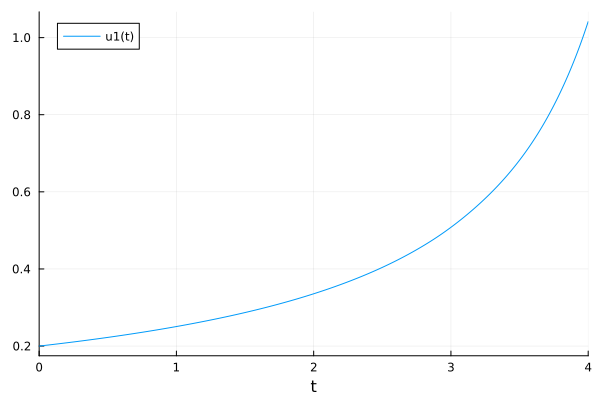

In [5]:
function f!(du,u,p,t)
# observe that specifying first component of u is required here
    du[1] = 1.01*u[1]*u[1]
end 

# observe that specifying u0 as a vector is required here 
u0 = [.2];

tspan = (0.,4.)
prob = ODEProblem(f!,u0,tspan)

sol = solve(prob)

plot(sol)

## Part 4/: Same example as before using Jacobian function

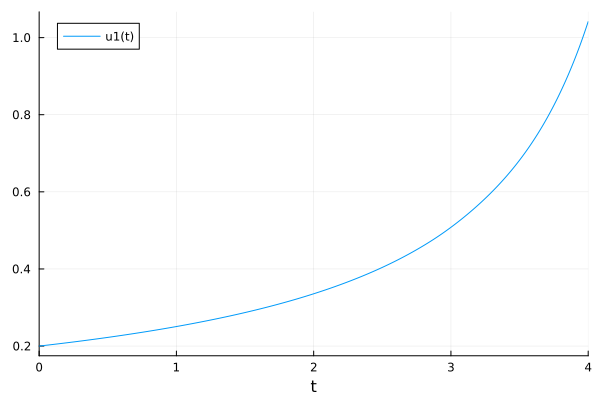

In [6]:
function f!(du,u,p,t)
# observe that specifying first component of u is required here
    du[1] = 1.01*u[1]*u[1]
end 

function j!(J,u,p,t)
# observe that specifying first component of u is required here
    J[1,1] = 2.02*u[1]
end 

# observe that specifying u0 as a vector is required here 
u0 = [.2];

# include jacobian in ODEFunction
ff = ODEFunction(f!, jac=j!)

tspan = [0.,4.]
prob = ODEProblem(ff,u0,tspan)

sol = solve(prob)

plot(sol,idx=(1))

 ## Part 5/: Coupled System Example: Lorenz

This example is taken from https://docs.sciml.ai/DiffEqDocs/stable/tutorials/ode_example/#Example-2:-Solving-Systems-of-Equations.

In this example we solve:

$$
\frac{dx}{dt} = \sigma(y-x)\\
\frac{dy}{dt} = x(\rho - z)-y \\
\frac{dz}{dt} = xy-\beta z
$$

with $\beta = 8/3$, $\sigma = 10$ and $\rho = 28$

In [7]:
function lorenz!(du,u,p,t)
 du[1] = 10.0*(u[2]-u[1])
 du[2] = u[1]*(28.0-u[3]) - u[2]
 du[3] = u[1]*u[2] - (8/3)*u[3]
end

lorenz! (generic function with 1 method)

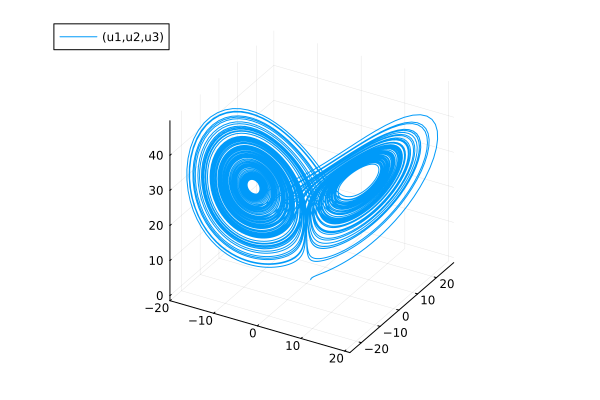

In [8]:
u0 = [1.0,0.0,0.0] # initial condition
tspan = (0.0,100.0) # time span

prob = ODEProblem(lorenz!,u0,tspan)

sol = solve(prob)

# plotly() # make the plots interactive if you want

plot(sol, idxs=(1,2,3))
# plot(sol)

## Part 6/: Coupled System Example: SIR 

Adapted from previous example to be able to arrive at chemical reactions in a next step.

In [9]:
function sir!(du,u,p,t)
 beta = 0.69 
 gamma = 0.3
 du[1] = -beta*u[2]*u[1]
 du[2] = beta*u[2]*u[1] - gamma*u[2]
 du[3] = gamma*u[2]
end

sir! (generic function with 1 method)

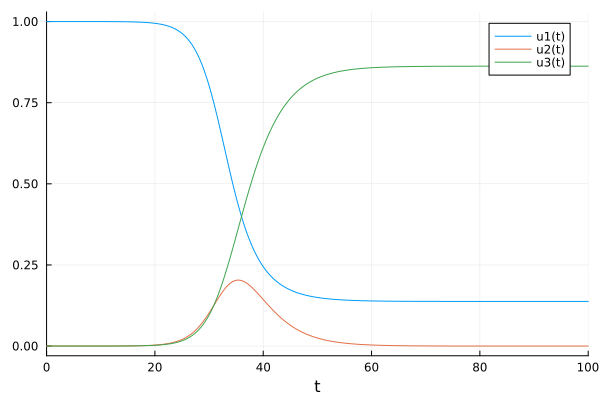

In [10]:
u0 = [1.0;1.27e-6;0.0]
tspan = (0.0,100.0)
prob = ODEProblem(sir!,u0,tspan)
sol = solve(prob)
plot(sol,idxs=1)
plot!(sol,idxs=2)
plot!(sol,idxs=3)

## Part 7/: Coupled System Example: Single Step Mechanism 

In [11]:
function methane!(du,u,p,t)
 k = 0.5 
 du[1] = -k*u[1]*u[2]*u[2]
 du[2] = -k*u[1]*u[2]*u[2]
 du[3] = k*u[1]*u[2]*u[2]
 du[4] = k*u[1]*u[2]*u[2]
end

methane! (generic function with 1 method)

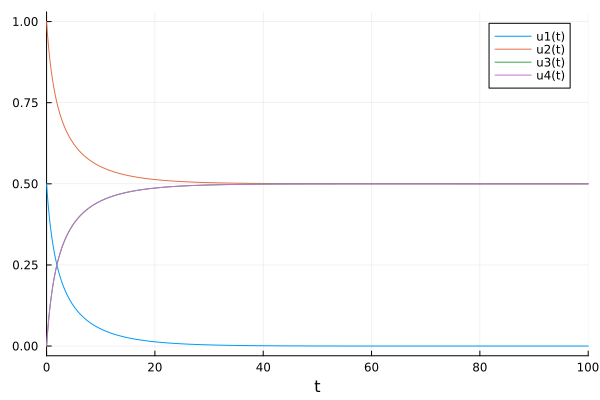

In [12]:
u0 = [0.5;1.0;0.0;0.0]
tspan = (0.0,100.0)
prob = ODEProblem(methane!,u0,tspan)
sol = solve(prob)
plot(sol,idxs=1)
plot!(sol,idxs=2)
plot!(sol,idxs=3)
plot!(sol,idxs=4)

##  Part 8/: Oscillating Mass-Spring System as Second Order ODE 

The example that follows was taken from here [https://stackoverflow.com/questions/60180865/2nd-order-odes-in-julia-using-differentialequations]. The way in which the problem is presented, however, contains a bug. Here we use the function `SecondOrderODEProblem` explained https://diffeq.sciml.ai/stable/solvers/dynamical_solve/ (solvers page) and https://diffeq.sciml.ai/stable/types/dynamical_types/ (problems page). 

In the notation of `SecondOrderODEProblem`, the velocity is numbered first. 

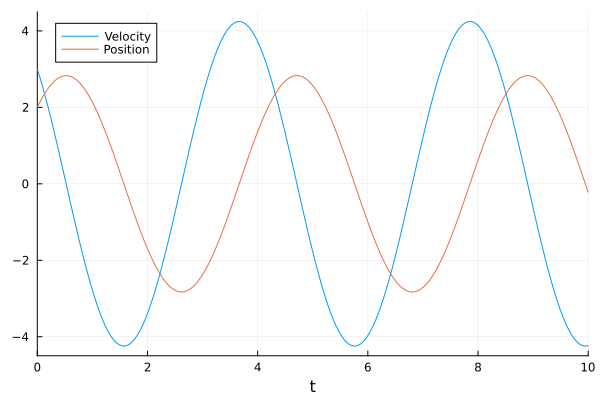

In [13]:
ω = 1.5                     

function mass_system!(ddu,u,p,t)
    # a(t) = -w^2 x 
    ddu = -(ω^2)*u 
end

v0 = 3.0                     
u0 = 2.0                  
tspan = (0.0,10.0)               

prob = SecondOrderODEProblem(mass_system!,v0,u0,tspan)
sol1 = solve(prob)
p1 = plot(sol1)
plot(sol1,idxs=1,label="Velocity")
plot!(sol1,idxs=2,label="Position")

#sol(1.0)

##  Part 8-2/: Oscillating Mass-Spring System as Coupled System of First Order ODEs 

The example that follows repeats what was done before using a coupled system of first order ODEs. We again use the Lorentz system as a guide. We place the velocity first. 

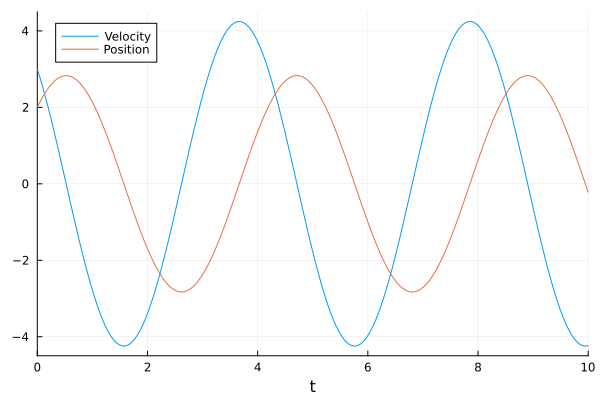

In [14]:
ω = 1.5                     

function mass_first_order_system!(du,u,p,t)
    # x'(t) = v(t)
    # v'(t) = -w^2 x
    du[2] = u[1]
    du[1] = -(ω^2)*u[2]
end

u0 = [3.0, 2.0]
tspan = (0.0,10.0)               

prob = ODEProblem(mass_first_order_system!, u0, tspan)
sol = solve(prob)

p2 = plot(sol)
plot(sol,idxs=1,label="Velocity")
plot!(sol,idxs=2,label="Position")


*Note on example 8.2 and 8.3:*

In Example 8.2 we directly solved the following 2nd order ODE

$$
\begin{align}
m \frac{d^{2}x}{dt^{2}}+ku = 0  \\
\frac{d^{2}x}{dt^{2}} = -\frac{k}{m}u = -\omega^{2}u
\end{align}
$$

using the `SecondOrderODEProblem` we solve the RHS of this problem, given the initial `v0` and `u0`.
<hr>

The second example we solve the same problem but first we rewrite it into the following system of first order ODEs:

$$\tag{1}
\begin{cases}
\dot{x} = v(t) \\
\ddot{x} = - \omega^{2}x(t)
\end{cases}
$$

In this case, the vector `u` represents both velocity and displacement as: $\mathbf{u} = \begin{bmatrix}v(t)\\x(t)\end{bmatrix}$
And the system of ODEs can be rewritten as:

$$
\dot{\mathbf{u}} = \begin{bmatrix}
1  \\
-\omega^{2}
\end{bmatrix}\cdot \mathbf{u}
$$
it follows then:
$$
\overbrace{ \begin{bmatrix}
\dot{v} \\
\dot{x}
\end{bmatrix} }^{ \text{du} } = \begin{bmatrix}
1 \\
-\omega^{2}
\end{bmatrix}\ \cdot \underbrace{ \begin{bmatrix}
v(t) \\
x(t)
\end{bmatrix} }_{ \text{u} }
$$

To satisfy $(1)$ we need :

$\dot{x}=v(t)$ which, in Julia is written as `du[2] = u[1]`, and

$\dot{v}=\ddot{x}=-\omega^{2}x(t)$ that can be written in Julia as `du[1] = -ω*ω*u[2]`

Below we plot both in the same graph so you see they're they yield the same result.

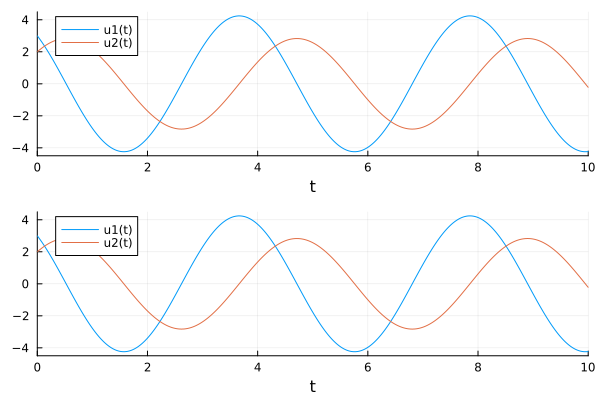

In [15]:
plot(p1,p2, layout=(2,1))

##  Part 8-3/: Another Oscillating Mass-Spring System as Second Order ODE

Here we construct a mock-up of a wave equation discretized in space and time. This example serves as intermediate to the next example. 

In [ ]:
function wave_system!(du,u,p,t)
    # du is here the acceleration
    du = -2*u 
end

#..fix initial positions 
v0 = 1
u0 = 2

tspan = (0.0,2.0)               

prob = SecondOrderODEProblem(wave_system!,v0,u0,tspan)
sol = solve(prob,DPRKN6(),reltol=1e-8,abstol=1e-8)

p1 = plot(sol)
plot(sol,idxs=1,label="Velocity")
plot!(sol,idxs=2,label="Position")

##  Part 8-4/: Another Oscillating Mass-Spring System as Coupled System of First Order ODEs

Here we construct a mock-up of a wave equation discretized in space and time. This example serves as intermediate to the next example. 

In [ ]:
function first_order_wave_system!(du,u,p,t)
    du[1] = -2*u[2]
    du[2] = u[1]  
end

#..fix initial positions 
u0 = [1.; 2.0] 

tspan = (0.0,2.0)               

prob = ODEProblem(first_order_wave_system!,u0,tspan)
# sol = solve(prob,DPRKN6(),reltol=1e-8,abstol=1e-8)
sol = solve(prob)

p1 = plot(sol)
plot(sol,idxs=1,label="Velocity")
plot!(sol,idxs=2,label="Position")

##  Part 8-5/: Sandbox for Trying Stuff Out 

In [ ]:
function first_order_wave_system!(du,u,p,t)
    du[1] = -2*u[2] + 0.01*u[2]*du[1]
    du[2] = u[1]  
end

#..fix initial positions 
u0 = [1.; 2.0] 

tspan = (0.0,2.0)               

prob = ODEProblem(first_order_wave_system!,u0,tspan)
# sol = solve(prob,DPRKN6(),reltol=1e-8,abstol=1e-8)
sol = solve(prob)

p1 = plot(sol)
plot(sol,idxs=1,label="Velocity")
plot!(sol,idxs=2,label="Position")

## Part 9:/ Boundary Value Problem for Scalar Diffusion 

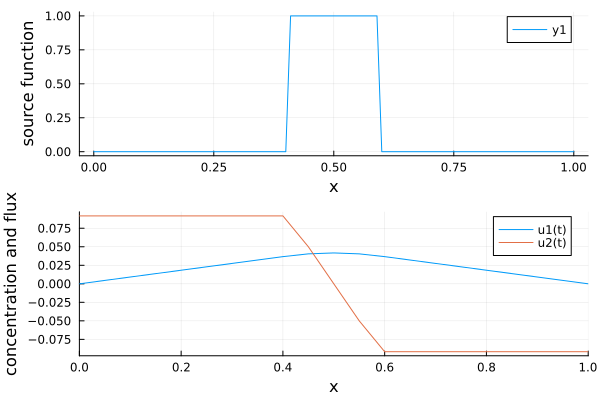

In [42]:
# solves the scalar diffusion equatiobn -d^2/dx^2 u(x) = f(x)
# on the interval 0 < x < 1 
# supplied with Dirichlet or Neumann boundary conditions 

using BoundaryValueDiffEq

# define spatial range 
xspan = (0.0, 1)

# define the source function f(x)
function sourceFct(x)
    return (x>0.4)*(x<0.6) 
end

# define diffusion equation 
function diffusion!(du, u, p, x)
    # u[1]: concentration 
    # u[2]: fluc 
    # d/dx(concentration)  = flux 
    du[1] = u[2]
    # d/dx(flux)  = sourceFct
    du[2] = - sourceFct(x)
end

# define boundary conditions 
function boundaries!(residual, u, p, x)
    # residual boundary condition in the left end-point 
    residual[1] = u[1][1] 
    # residual boundary condition in the left end-point
    residual[2] = u[end][1]
end 

# set the boundary value problem to solve  
bvp1 = BVProblem(diffusion!, boundaries!, [1., 1.], xspan)

# set the boundary value problem  
sol1 = solve(bvp1, GeneralMIRK4(), dt = 0.05)

# plot the computed solution
xvec = Vector(xspan[1]:(xspan[2]-xspan[1])/100:xspan[2])
fvec = sourceFct.(xvec)
p1 = plot(xvec,fvec)
xlabel!("x") 
ylabel!("source function")

p2 = plot(sol1)
xlabel!("x") 
ylabel!("concentration and flux")

plot(p1,p2,layout=(2,1))

##  Part 10/: Second Order Vector-Valued Example: PDE discretized on coarse spatial mesh

Here we construct a mock-up of a wave equation discretized in space and time. This example serves as intermediate to the next example. 

In [ ]:
h = 1/3; h2 = h*h;
h = 1; h2 = h*h;

#..observe that matrix is zero in first and last row to preserve the boundary conditions 

A = [0 0 0 0; 
    1/h2 -2/h2 1/h2 0; 
    0 1/h2 -2/h2 1/h2; 
    0 0 0 0]

function wave_system!(du,u,p,t)
    du = A*u 
end

#..fix initial velocities
v0 = zeros(4,1)
v0[2]=1; v0[3]=-1; 

#..fix initial positions 
u0 = zeros(4,1); 
u0[1]=0; u0[2]=2; u0[3]=2; u0[4]=1;

tspan = (0.0,2.0)               

prob = SecondOrderODEProblem(wave_system!,v0,u0,tspan)
sol = solve(prob,DPRKN6(),reltol=1e-8,abstol=1e-8)

plot(sol,idxs=5,label="Pos-1")
p1=plot!(sol,idxs=8,label="Pos-4")

plot(sol,idxs=6,label="Pos-2")
p2=plot!(sol,idxs=7,label="Pos-3")

plot(p1,p2,layout=(2,1))

##  Part 10-bis/: PDE discretized on coarse spatial mesh as system of coupled ODES

Here we construct a mock-up of a wave equation discretized in space and time. This example serves as intermediate to the next example. 

In [ ]:
h = 1/3; h2 = h*h;
h = 1; h2 = h*h;
# A = [1. 0 0 0; 1/h2 -2/h2 1/h2 0; 0 1/h2 -2/h2 1/h2; 0 0 0 1.]
A = [0. 0 0 0; 1/h2 -2/h2 1/h2 0; 0 1/h2 -2/h2 1/h2; 0 0 0 0.]

function trial_wave_first_order_system!(du,u,p,t)
    du[1] = 0 #u[5]
    du[2] = u[6]
    du[3] = u[7]
    du[4] = u[8]
    du[5] = 0
    du[6] = (-2/h2)*u[2] + (1/h2)*u[3]
    du[7] = (-2/h2)*u[3] + (1/h2)*u[2]
    du[8] = 0
end

function wave_first_order_system!(du,u,p,t)
    du[1:4] = A*u[5:8] + 0.1*du[1:4].*u[5:8]
    du[5:8] = u[1:4]
end

#..fix initial velocities 
u0 = zeros(8,1); 
u0[1]=0; u0[2]=1; u0[3]=-1; u0[4]=0;

#..fix initial positions 
u0[5]=0; u0[6]=2; u0[7]=2; u0[8]=1;

tspan = (0.0,2.0)               

prob = ODEProblem(wave_first_order_system!,u0,tspan)
sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8)

plot(sol,vars=5,label="Pos-1")
p1=plot!(sol,vars=8,label="Pos-4")

plot(sol,vars=6,label="Pos-2")
p2=plot!(sol,vars=7,label="Pos-3")

plot(sol,vars=1,label="Vel-1")
p3=plot!(sol,vars=4,label="Vel-4")

plot(sol,vars=2,label="Vel-2")
p4=plot!(sol,vars=3,label="Vel-3")

plot(p1,p2,layout=(2,1))

## Part 11/: Traveling Wave Solution as a Second Order System

Traveling wave solution as a second order system.

In [ ]:
#..how is initial condition formulated - how to ensure that wave travels in one direction only? 
#..how to make use of PartionedArray - how to extend to 2D and 3D? 
#..what exactly is the syntax for second order differential equations ? 
#..how to extend to the Westerveld equation ?

#..Define analytical reference solution and as initial condition 
#..We choose as reference solution a Gauss pulse travelling to the right
#..The part of the d'Alembert solution traveling to the left is not taken into account (set to zero)  
#..c:  velocity of propagation 
#..x0: center of the Gauss pulse 
#..sigma: width of the Gauss pulse 
function gauss_pulse(x,t,c,x0,sigma)
    xi = x - c*t; 
    return exp(-(xi-x0)^2/sigma^2)
end

#..Define the time-derivative of the analytical solution as reference and initial velocity. 
function ddt_gauss_pulse(x,t,c,x0,sigma)
    # d/dt [f(xi)] = d/dt[exp(-(xi-x0)^2)/sigma^2] = [exp(-(xi-x0)^2)/sigma^2]*[-2*(xi-x0)/sigma^2]*[d xi / dt]
    # = [exp(-(xi-x0)^2)/sigma^2]*[-2*(xi-x0)/sigma^2]*[-c]
    xi = x - c*t;
    return exp(-(xi-x0)^2/sigma^2)*(-2*(xi-x0)/sigma^2)*(-c)
end

#..construct the 1D spatial mesh
N = 100; Np1 = N+1;
h = 1/N; h2 = h*h;
x = Vector(0:h:1); 

#..define matrix resulting from spatial discretization 
e = ones(Np1); #..note that ones(N+1,1) does *not* work here 
A = Tridiagonal(e[2:end], -2*e, e[2:end]); 
A = (1/h2)*A; 
A[1,1] = 0;          A[1,2] = 0;         
A[end,end-1]=0;      A[end,end] = 0;       

#..define RHS of the ODE (the Jacobian should be easy to include here)
function wave_first_order_system!(du,u,p,t)
    c^2*A*u
end

#..define initial position and initial velocity   
c = .2; #..wave velocity 
v0 = zeros(Np1,1); # 2 dimensions essential here  
v0[1:end,1] = ddt_gauss_pulse.(x,0,c,0.3,0.1) 
u0 = zeros(Np1,1); # 2 dimensions essential here  
u0[1:end,1] = gauss_pulse.(x,0,c,0.3,0.1) 

#..define time-span 
tend = 2.0
tspan = (0.0,tend)               

#..define and solve problem
prob = SecondOrderODEProblem(wave_system!,v0,u0,tspan)
sol = solve(prob,DPRKN6(),reltol=1e-8,abstol=1e-8)

#..Do clumky homebrewed post-processing 
tsampled = (0:0.01:tend)
Ntsampled = length(tsampled)  
U = zeros(Np1,Ntsampled); V = zeros(Np1,Ntsampled); 
k=1; for tk in tsampled V[:,k] = sol(tk)[1:Np1]; k=k+1; end
k=1; for tk in tsampled U[:,k] = sol(tk)[Np1+1:end]; k=k+1; end

#..plot the computed solution  
p1=contour(tsampled,x,U)
xlabel!("t") 
ylabel!("x")
#..plot the computed solution  
p2=surface(tsampled,x,U)
xlabel!("t") 
ylabel!("x")

p3 = plot(p1,p2,layout=(2,1))
#savefig(p3,"myfigure.png")

## Part 12/: Traveling Wave Solution as a Coupled First Order System

Traveling wave solution as a coupled first order system. 

In [ ]:
#..how is initial condition formulated - how to ensure that wave travels in one direction only? 
#..how to make use of PartionedArray - how to extend to 2D and 3D? 
#..what exactly is the syntax for second order differential equations ? 
#..how to extend to the Westerveld equation ?

#..Define analytical reference solution and as initial condition 
#..We choose as reference solution a Gauss pulse travelling to the right
#..The part of the d'Alembert solution traveling to the left is not taken into account (set to zero)  
#..c:  velocity of propagation 
#..x0: center of the Gauss pulse 
#..sigma: width of the Gauss pulse 
function gauss_pulse(x,t,c,x0,sigma)
    xi = x - c*t; 
    return exp(-(xi-x0)^2/sigma^2)
end

#..Define the time-derivative of the analytical solution as reference and initial velocity. 
function ddt_gauss_pulse(x,t,c,x0,sigma)
    # d/dt [f(xi)] = d/dt[exp(-(xi-x0)^2)/sigma^2] = [exp(-(xi-x0)^2)/sigma^2]*[-2*(xi-x0)/sigma^2]*[d xi / dt]
    # = [exp(-(xi-x0)^2)/sigma^2]*[-2*(xi-x0)/sigma^2]*[-c]
    xi = x - c*t;
    return exp(-(xi-x0)^2/sigma^2)*(-2*(xi-x0)/sigma^2)*(-c)
end

#..construct the 1D spatial mesh
N = 100; Np1 = N+1;
h = 1/N; h2 = h*h;
x = Vector(0:h:1); 

#..define matrix resulting from spatial discretization 
e = ones(Np1); #..note that ones(N+1,1) does *not* work here 
A = Tridiagonal(e[2:end], -2*e, e[2:end]); 
A = (1/h2)*A; 
A[1,1] = 0;          A[1,2] = 0;         
A[end,end-1]=0;      A[end,end] = 0;       

#..define RHS of the ODE (the Jacobian should be easy to include here)
function wave_first_order_system!(du,u,p,t)
    du[1:Np1] = c^2*A*u[Np1+1:end]
    du[Np1+1:end] = u[1:Np1]
end

#..define initial position and initial velocity   
c = .2; #..wave velocity 
u0 = zeros(2*Np1,1); # 2 dimensions essential here  
u0[1:Np1,1] = ddt_gauss_pulse.(x,0,c,0.3,0.1) 
u0[Np1+1:end,1] = gauss_pulse.(x,0,c,0.3,0.1) 

#..define time-span 
tend = 2.0
tspan = (0.0,tend)               

#..define and solve problem
prob = ODEProblem(wave_first_order_system!,u0,tspan)
sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8)

#..Do clumky homebrewed post-processing 
tsampled = (0:0.01:tend)
Ntsampled = length(tsampled)  
U = zeros(Np1,Ntsampled); V = zeros(Np1,Ntsampled); 
k=1; for tk in tsampled V[:,k] = sol(tk)[1:Np1]; k=k+1; end
k=1; for tk in tsampled U[:,k] = sol(tk)[Np1+1:end]; k=k+1; end

#..plot the computed solution  
p1=contour(tsampled,x,U)
xlabel!("t") 
ylabel!("x")
#..plot the computed solution  
p2=surface(tsampled,x,U)
xlabel!("t") 
ylabel!("x")

p3 = plot(p1,p2,layout=(2,1))
#savefig(p3,"myfigure.png")

## Part 13/: Westervelt Equation as a Coupled First Order System

For the Westervelt equation, see [https://en.wikipedia.org/wiki/Nonlinear_acoustics]. 
$ \frac{\partial^{2} p}{\partial t^{2}} 
= c_{0}^{2} \bigtriangleup p + \frac{\beta}{\rho_{0} c_{0}^{2}} \frac{\partial^{2} p^{2}}{\partial t^{2}} 
= c_{0}^{2} \bigtriangleup p + \frac{\beta}{\rho_{0} c_{0}^{2}} 
  \left[ 2 \, p \, \frac{\partial^{2} p}{\partial t^{2}} + 2 \left( \frac{\partial p}{\partial t}\right)^2 \right]$

In [ ]:
#..how is initial condition formulated - how to ensure that wave travels in one direction only? 
#..how to make use of PartionedArray - how to extend to 2D and 3D? 
#..what exactly is the syntax for second order differential equations ? 
#..how to extend to the Westerveld equation ?

#..Define analytical reference solution and as initial condition 
#..We choose as reference solution a Gauss pulse travelling to the right
#..The part of the d'Alembert solution traveling to the left is not taken into account (set to zero)  
#..c:  velocity of propagation 
#..x0: center of the Gauss pulse 
#..sigma: width of the Gauss pulse 
function gauss_pulse(x,t,c,x0,sigma)
    xi = x - c*t; 
    return exp(-(xi-x0)^2/sigma^2)
end

#..Define the time-derivative of the analytical solution as reference and initial velocity. 
function ddt_gauss_pulse(x,t,c,x0,sigma)
    # d/dt [f(xi)] = d/dt[exp(-(xi-x0)^2)/sigma^2] = [exp(-(xi-x0)^2)/sigma^2]*[-2*(xi-x0)/sigma^2]*[d xi / dt]
    # = [exp(-(xi-x0)^2)/sigma^2]*[-2*(xi-x0)/sigma^2]*[-c]
    xi = x - c*t;
    return exp(-(xi-x0)^2/sigma^2)*(-2*(xi-x0)/sigma^2)*(-c)
end

#..construct the 1D spatial mesh
N = 100; Np1 = N+1;
h = 1/N; h2 = h*h;
x = Vector(0:h:1); 

#..define matrix resulting from spatial discretization 
e = ones(Np1); #..note that ones(N+1,1) does *not* work here 
A = Tridiagonal(e[2:end], -2*e, e[2:end]); 
A = (1/h2)*A; 
A[1,1] = 0;          A[1,2] = 0;         
A[end,end-1]=0;      A[end,end] = 0;       

#..define RHS of the ODE (the Jacobian should be easy to include here)
function wave_first_order_system!(du,u,p,t)
    du[1:Np1] = c^2*A*u[Np1+1:end] + 0.15*( 2*u[1:Np1].*u[1:Np1] + 2*u[Np1+1:end].*du[1:Np1] )
    du[Np1+1:end] = u[1:Np1]
end

#..define initial position and initial velocity   
c = .2; #..wave velocity 
u0 = zeros(2*Np1,1); # 2 dimensions essential here  
u0[1:Np1,1] = ddt_gauss_pulse.(x,0,c,0.3,0.1) 
u0[Np1+1:end,1] = gauss_pulse.(x,0,c,0.3,0.1) 

#..define time-span 
tend = 2.0
tspan = (0.0,tend)               

#..define and solve problem
prob = ODEProblem(wave_first_order_system!,u0,tspan)
#sol = solve(prob,TRBDF2(),reltol=1e-2,abstol=1e-2)
sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8)

#..Do clumky homebrewed post-processing 
tsampled = (0:0.01:tend)
Ntsampled = length(tsampled)  
U = zeros(Np1,Ntsampled); V = zeros(Np1,Ntsampled); 
k=1; for tk in tsampled V[:,k] = sol(tk)[1:Np1]; k=k+1; end
k=1; for tk in tsampled U[:,k] = sol(tk)[Np1+1:end]; k=k+1; end

#..plot the computed solution  
p1=contour(tsampled,x,U)
xlabel!("t") 
ylabel!("x")
#..plot the computed solution  
p2=surface(tsampled,x,U)
xlabel!("t") 
ylabel!("x")

p3 = plot(p1,p2,layout=(2,1))
#savefig(p3,"myfigure.png")

## First Test With the ModelingToolkit

In [ ]:
@variables x 

# Define a nonlinear system
eqs = [0 ~ x*x]
ns = NonlinearSystem(eqs, [x])
nlsys_func = generate_function(ns)[2] # second is the inplace version

In [ ]:
fff = eval(nlsys_func)[1]
du = 0; u = 2
fff(du,u)
du